In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# Problem 1a
import fsps

SPS_age = 13.5
SPS_FeH = 0
assumed_dist = 10 # pc 
c = 3e8 # m/s
pc = 3.086e18 # cm 

const_SPS = fsps.StellarPopulation(compute_vega_mags = False, sfh=1, const = 1,
                dust_type=0, sf_start=0, zcontinuous = 1, logzsol = SPS_FeH, 
                redshift_colors = False, zred = 0)

filter_name, fuv_filter = ['galex_fuv'], fsps.get_filter('galex_fuv')
fuv_lambda_eff = fuv_filter.lambda_eff
FUV_mag = const_SPS.get_mags(tage=SPS_age, bands=filter_name, redshift = 0)

def get_nu_Lnu_from_mag(mag, lambda_eff, dist = 10):
    # lambda_eff in AA
    # dist in pc
    nu = c/(lambda_eff*1e-10) # Hz
    log_Fnu = -(2/5)*(mag + 48.6)
    Fnu = 10**(log_Fnu)
    dist_cm = dist*pc
    Lnu = Fnu * 4 * np.pi * dist_cm**2
    nu_Lnu = nu*Lnu
    return nu_Lnu # in erg s^-1 

def get_C_FUV_from_nu_Lnu(nu_Lnu, age):
    # nu_Lnu in erg/s
    # age in Gyr
    SFR = 1/(age*1e9) 
    log_Cx = np.log10(nu_Lnu) - np.log10(SFR)
    return log_Cx

nu_Lnu = get_nu_Lnu_from_mag(mag = FUV_mag, 
            lambda_eff= fuv_lambda_eff, dist = assumed_dist)
C_FUV = get_C_FUV_from_nu_Lnu(nu_Lnu, age = SPS_age)
print("log(C_FUV): %.2f" % C_FUV)

log(C_FUV): 43.39


This is very close to the value 43.35 found in Kennicutt & Evans 2012. Surprisingly close, given all the assumptions we made. We used different stellar models, and we assumed the SFH was constant over the age of the universe. 

In [4]:
# Problem 2
filter_nameB, B_filter = ['B'], fsps.get_filter('B')
B_lambda_eff = B_filter.lambda_eff
B_mag = const_SPS.get_mags(tage = SPS_age, bands=filter_nameB, redshift = 0)
print("M_star = 1 M_sun corresponds to an absolute B magnitude of %.2f" % B_mag)

# Note B_band is a bad tracer of M_star because it's mostly sensitive to young stars

M_star = 1 M_sun corresponds to an absolute B magnitude of 5.73


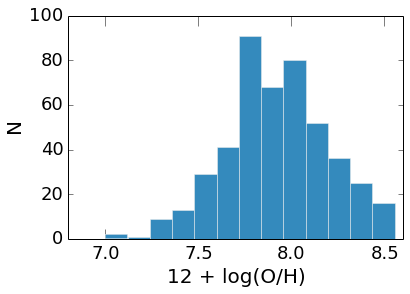

In [5]:
# Problem 3
data = np.genfromtxt('ps5.data')
data[data == 99.99] = np.nan
B_mags_AB = data[:, 8]
B_mags_AB_err = 0.1*np.ones(len(B_mags_AB))
dists_Mpc = data[:, 7]

def get_M_b(b_mag, dists_Mpc):
    b_mag += 0.09 # conversion from AB to Vega mags
    dist_pc = dists_Mpc * 1e6
    mu = 5*np.log10(dist_pc) - 5
    M_b = b_mag - mu
    return M_b

def get_12_plus_log_O_H_Berg_2012(M_b, slope_scatter = 0, offset_scatter = 0):
    '''
    they find 
    12 + log(O/H) = (6.27 ± 0.21) + (−0.11 ± 0.01)MB
    from their figure 3, there's quite a lot of scatter in this
    relation, but oh well
    to account for this scatter, could draw slope_scatter and offset_scatter
    from gaussians of with 0.21 and 0.01
    '''
    return (6.27 + offset_scatter) + (-0.11 + offset_scatter)*M_b

M_bs = get_M_b(b_mag = B_mags_AB, dists_Mpc = dists_Mpc)
_12_log_OH = get_12_plus_log_O_H_Berg_2012(M_bs)
f = plt.figure()
ax = f.add_subplot(111)
ax.hist(_12_log_OH, bins = 'scott')
ax.set_xlabel('12 + log(O/H)', fontsize=20)
ax.set_ylabel('N', fontsize=20)
ax.xaxis.set_tick_params(labelsize = 18)
ax.yaxis.set_tick_params(labelsize = 18)


/Users/kareem/Desktop/Ureka/python/lib/python2.7/site-packages/matplotlib-1.3.1-py2.7-macosx-10.6-x86_64.egg/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


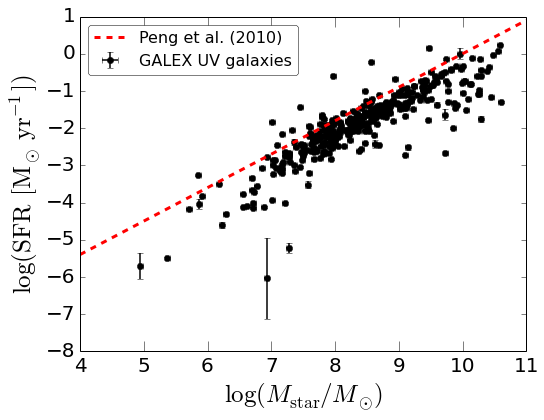

In [6]:
# Problem 4a
mag_FUV, mag_FUV_err, B_mags_AB, dists_Mpc = data[:, 11], data[:, 12],  data[:, 8], data[:, 7]
mask = np.isfinite(mag_FUV) & np.isfinite(mag_FUV_err) & np.isfinite(dists_Mpc)
mag_FUV, mag_FUV_err, dists_Mpc, B_mags_AB = mag_FUV[mask], mag_FUV_err[mask], dists_Mpc[mask], B_mags_AB[mask]
B_mags_AB_err = 0.1*np.ones(len(B_mags_AB))


# translate to F_nu from AB mag
f_nu_FUV = 10**(-(2/5)*(mag_FUV + 48.6)) # in  erg s−1 cm−2 Hz−1
f_nu_FUV_err = np.sqrt((f_nu_FUV * np.log(10) * (-2/5))**2 * mag_FUV_err**2)

# translate from F_nu to L_nu. Assume no distance errors...
cm_per_Mpc = 3.086 * 1e24
L_nu_FUV = f_nu_FUV * 4 * np.pi * (dists_Mpc*cm_per_Mpc)**2  # in  erg s−1 Hz−1
L_nu_FUV_err = f_nu_FUV_err * 4 * np.pi * (dists_Mpc*cm_per_Mpc)**2

# translate to nu*L_nu

nu = c/(fuv_lambda_eff * 1e-10)
Nu_Lnu_FUV = nu*L_nu_FUV # in  erg s−1 
Nu_Lnu_FUV_err = nu * L_nu_FUV_err

# translate to log(SFR)
C_FUV = 43.35
log_SFR = np.log10(Nu_Lnu_FUV) - C_FUV
log_SFR_err = (1/(np.log(10)*Nu_Lnu_FUV))*Nu_Lnu_FUV_err

def get_Mstar_from_M_b(M_b):
    '''
    based on problem 2. Returns value in M_sun. 
    '''
    M_0 = 1 # M_sun
    mag_0 = 5.73 
    return M_0 * 10**((mag_0 - M_b)/2.5)

# translate b mags to absolute mags, assuming no error in distance
dist_pc = dists_Mpc * 1e6
mu = 5*np.log10(dist_pc) - 5
B_mags = B_mags_AB 
M_B = B_mags - mu
M_b_errs = B_mags_AB_err
M_stars = get_Mstar_from_M_b(M_B)
M_stars_errs = M_stars * np.log(10)/2.5 * M_b_errs

log_M_stars = np.log10(M_stars)
log_M_stars_err = M_stars_errs/(M_stars*np.log(10))

# metallicities for later
_12_log_OH = get_12_plus_log_O_H_Berg_2012(M_B)
_12_log_OH_err = np.sqrt((-0.11)**2 * M_b_errs**2)


f = plt.figure(figsize=(8, 6))
ax = f.add_subplot(111)
ax.errorbar(log_M_stars, log_SFR, xerr = log_M_stars_err, 
    yerr = log_SFR_err, fmt = 'ko', label = 'GALEX UV galaxies')
ax.set_xlabel(r'$\log(M_{\rm star}/M_{\odot})$', fontsize = 25)
ax.set_ylabel(r'$\log(\rm SFR\,[M_{\odot}\,yr^{-1}])$', fontsize = 25)
ax.yaxis.set_tick_params(labelsize = 20)
ax.xaxis.set_tick_params(labelsize = 20)
xx = np.linspace(4, 11)
Peng2010 = 0.9*xx - 9
ax.plot(xx, Peng2010, '--r', lw = 3, label = 'Peng et al. (2010)')
ax.legend(loc = 'best', fontsize = 16)

# I've overplotted the z = 0 "star forming main sequence" from Peng et al. 2010. 
# It's clearly a bit too high. Maybe this means our B-band mass-to-light ratio is 
# too high

In [7]:
# now fit a line. We'll assume that the uncertainties are under-reported,
# since we didn't account for distance errors or the scatter in the 
# B-band mass-to-light ratios. 

# Unlike in previous cases, we now have uncertainties in both x and y. How 
# to deal with this properly is explained in Chapter 7 of the Hogg et al. 2010
# document we read at the beginning of the term. However, it's fairly complicated,
# and our x errors seem fairly small, so I'm going to prentend we know M_star 
# exactly. 
import emcee

def get_good_p0_ball(p0, theta_bounds, nwalkers):
    num_good_p0 = 0
    ball_of_p0 = []
    while num_good_p0 < nwalkers:
        suggested_p0 = p0 + np.array([0.2*j*np.random.randn() for j in p0])
        suggested_p0_prob = ln_flat_prior(suggested_p0, theta_bounds = theta_bounds)
        
        if np.isfinite(suggested_p0_prob):
            ball_of_p0.append(suggested_p0)
            num_good_p0 += 1
    print("finished initializing walkers...")
    return ball_of_p0

def theta_is_within_bounds(theta, theta_bounds):
    '''
    theta should be an array of floats
    theta_bounds should be an array of 3 of e.g. [0, None], or [0, 20] 
    If there's a None, the prior won't be proper, so handle with care. 
    '''
    for i, param in enumerate(theta):
        this_min, this_max  = theta_bounds[i]
        
        if this_min is None:
            this_min = -np.inf
        if this_max is None:
            this_max = np.inf
        if not (this_min <= param < this_max):
            return False
    return True

def ln_flat_prior(theta, theta_bounds):
    '''
    theta is a vector, normally something like [alpha, m_max].
    theta is a vector of the same length, but with a list of length
        two (lower and upper bounds) at each element
    '''
    if theta_is_within_bounds(theta, theta_bounds):
        return 0
    else: 
        return -np.inf

def model_y(m, b, x_i):
    '''
    a line
    '''
    return m*x_i + b

def ln_likelihood(theta, x_data, y_data, yerr):
    '''
    Here our model is log_xi = m*x + b. I'll assume the 
    points all have the same uncertainty ln_sigma (use log since
    it has to be postive)
    '''
    m, b, ln_sigma = theta
    y_hat = model_y(m = m, b = b, x_i = x_data)
    sigma2 = yerr**2 + np.exp(2*ln_sigma)
    
    return -0.5*(np.sum((y_data-y_hat)**2/sigma2 + np.log(2*np.pi*sigma2)))    
    
def ln_post(theta, theta_bounds, x_data, y_data, yerr):
    '''
    just ln_prior + ln_likelihood
    '''
    lnprior = ln_flat_prior(theta = theta, theta_bounds = theta_bounds)
    
    if np.isfinite(lnprior):
        lnlikelihood = ln_likelihood(theta = theta, x_data = x_data, 
                            y_data = y_data, yerr = yerr)
    else:
        lnlikelihood = 0 
    return lnprior + lnlikelihood


def run_mcmc_line(p0, theta_bounds, x_data, y_data, yerr, 
                  nwalkers = 100, n_steps = 500, burn = 50):
    '''
    returns a sampler object
    '''
    ndim = len(p0)
    p0_ball = get_good_p0_ball(p0 = p0, theta_bounds = theta_bounds, nwalkers = nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post, args=[theta_bounds, x_data, y_data, yerr])
    pos, prob, state = sampler.run_mcmc(p0_ball, burn)
    
    sampler.reset()
    print('completed burn in ...')
    
    # now the main production run
    sampler.run_mcmc(pos, n_steps)
    return sampler

def get_uncorrelated_samples(N, flatchain):
    ints = np.random.randint(low = 0, high = len(flatchain), size = N)
    return flatchain[ints]

finished initializing walkers...
completed burn in ...


/Users/kareem/Desktop/Ureka/python/lib/python2.7/site-packages/matplotlib-1.3.1-py2.7-macosx-10.6-x86_64.egg/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':


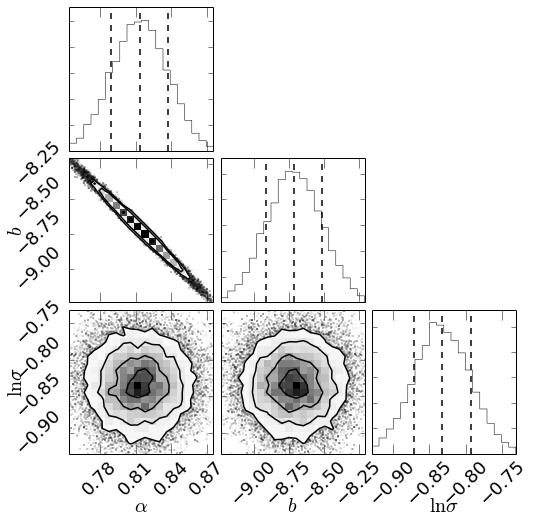

In [8]:
sampler = run_mcmc_line(p0 = [0.8, -9, 0.1], 
            theta_bounds = [[0.5, 1.5], [-10, -5], [-2, 2]], 
                x_data = log_M_stars, y_data = log_SFR, yerr = log_SFR_err,
                nwalkers = 100, n_steps = 500, burn = 100)

import corner
fig = corner.corner(sampler.flatchain, range = [0.99, 0.99, 0.99], 
        labels = [r'$\alpha$', r'$b$', r'$\ln \sigma$'],
        label_kwargs={"fontsize": 20}, quantiles=[0.159, 0.5, 0.841])

axes = fig.get_axes()

for i, ax in enumerate(axes):
    ax.grid(False)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.xaxis.set_tick_params(labelsize = 18)

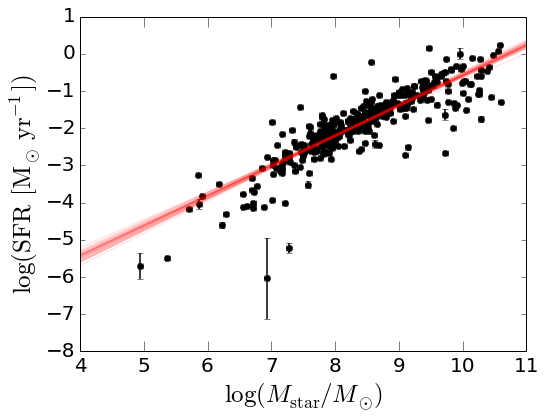

In [9]:
f = plt.figure(figsize=(8, 6))
ax = f.add_subplot(111)
ax.errorbar(log_M_stars, log_SFR, xerr = log_M_stars_err, 
    yerr = log_SFR_err, fmt = 'ko', label = 'GALEX UV galaxies')
ax.set_xlabel(r'$\log(M_{\rm star}/M_{\odot})$', fontsize = 25)
ax.set_ylabel(r'$\log(\rm SFR\,[M_{\odot}\,yr^{-1}])$', fontsize = 25)
ax.yaxis.set_tick_params(labelsize = 20)
ax.xaxis.set_tick_params(labelsize = 20)
samples = get_uncorrelated_samples(N = 30, flatchain = sampler.flatchain)
xx = np.linspace(4, 11)
for i, line in enumerate(samples):
    m, b, lnsig = line
    ax.plot(xx, model_y(m, b, xx), 'r', alpha = 0.1)
    

finished initializing walkers...
completed burn in ...


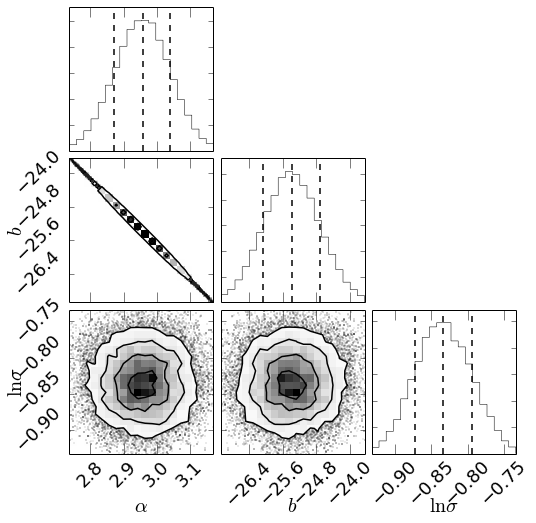

In [10]:
# problem 4c

sampler = run_mcmc_line(p0 = [3, -25, 0.1], 
            theta_bounds = [[2, 4], [-30, -20], [-2, 2]], 
                x_data = _12_log_OH, y_data = log_SFR, yerr = log_SFR_err,
                nwalkers = 100, n_steps = 500, burn = 100)

import corner
fig = corner.corner(sampler.flatchain, range = [0.99, 0.99, 0.99], 
        labels = [r'$\alpha$', r'$b$', r'$\ln \sigma$'],
        label_kwargs={"fontsize": 20}, quantiles=[0.159, 0.5, 0.841])

axes = fig.get_axes()

for i, ax in enumerate(axes):
    ax.grid(False)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.xaxis.set_tick_params(labelsize = 18)

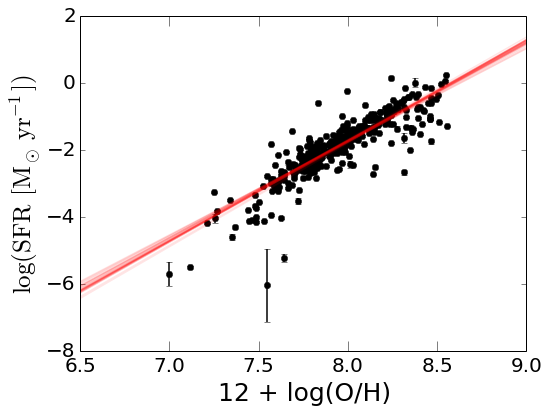

In [11]:
f = plt.figure(figsize=(8, 6))
ax = f.add_subplot(111)
ax.errorbar(_12_log_OH, log_SFR, xerr = _12_log_OH_err, 
    yerr = log_SFR_err, fmt = 'ko', label = 'GALEX UV galaxies')
ax.set_xlabel('12 + log(O/H)', fontsize = 25)
ax.set_ylabel(r'$\log(\rm SFR\,[M_{\odot}\,yr^{-1}])$', fontsize = 25)
ax.yaxis.set_tick_params(labelsize = 20)
ax.xaxis.set_tick_params(labelsize = 20)
samples = get_uncorrelated_samples(N = 30, flatchain = sampler.flatchain)
xx = np.linspace(6.5, 9)
for i, line in enumerate(samples):
    m, b, lnsig = line
    ax.plot(xx, model_y(m, b, xx), 'r', alpha = 0.1)



I find an intrinsic scatter of about 0.4 dex in both relations. This isn't surprising, since in both cases we are plotting SFR vs a quantity that's a linear transformation of $M_B$. 

It's obviously not good to get both M_star and metallicity from M_B. For M_star, an infrared filter would be better, and for metallicity, it'd be better to directly look at lines like [O III]. 